In [52]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import balanced_accuracy_score, roc_auc_score, make_scorer
from sklearn.model_selection import GridSearchCV # for cross validation
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report

### Import the data

In [2]:
df = pd.read_csv('./WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
# check unique values in each column
for column in df.columns:
    print("Column {} unique values: {}".format(column, df[column].unique()))

Column customerID unique values: ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
Column gender unique values: ['Female' 'Male']
Column SeniorCitizen unique values: [0 1]
Column Partner unique values: ['Yes' 'No']
Column Dependents unique values: ['No' 'Yes']
Column tenure unique values: [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39]
Column PhoneService unique values: ['No' 'Yes']
Column MultipleLines unique values: ['No phone service' 'No' 'Yes']
Column InternetService unique values: ['DSL' 'Fiber optic' 'No']
Column OnlineSecurity unique values: ['No' 'Yes' 'No internet service']
Column OnlineBackup unique values: ['Yes' 'No' 'No internet service']
Column DeviceProtection unique values: ['No' 'Yes' 'No internet service']
Column TechSupport unique values: ['No' 'Yes' 'No inte

#### 3 Groups of Variables
**(1) Demographic Information**
- gender
- SeniorCitizen
- Partner
- Dependents

**(2) Customer Account Information**
- tenure
- Contract
- PaperlessBilling
- PaymentMethod
- MontlyCharges
- TotalCharges

**(3) Services Information**
- PhoneService
- MultipleLines
- InternetServices
- OnlineSecurity
- OnlineBackup
- DeviceProtection
- TechSupport
- StreamingTV
- StreamingMovies

## Exploratory Data Analysis and Data Cleaning

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


**Total Charges has wrong type -> change to numeric**

In [5]:
# the argument errors='coerce' to skip those cases and replace them (blank space in this case) with a NaN
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors = 'coerce')

In [6]:
# Check missing data in 'TotalCharges'
df[df['TotalCharges'].isnull()]

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
753,3115-CZMZD,Male,0,No,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
936,5709-LVOEQ,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,...,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
1082,4367-NUYAO,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No
1340,1371-DWPAZ,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,...,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No
3331,7644-OMVMY,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,No
3826,3213-VVOLG,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,No
4380,2520-SGTTA,Female,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,No
5218,2923-ARZLG,Male,0,Yes,Yes,0,Yes,No,No,No internet service,...,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No
6670,4075-WKNIU,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,...,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,No


**All these 11 records have tenure = 0 -> these people might just join & # samples is small -> replace missing value with 0**

In [7]:
# remove rows with missing data
df.loc[df['TotalCharges'] == 0]
# remove customerID cause it is not related to whether the customer will churn
df.drop(columns = ['customerID'], inplace = True)

In [8]:
# replace all whitespace with "_" -> only for picture of XGBoost tree
df.replace(" ","_", regex = True, inplace = True)
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No_phone_service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic_check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One_year,No,Mailed_check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed_check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No_phone_service,DSL,Yes,No,Yes,Yes,No,No,One_year,No,Bank_transfer_(automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber_optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic_check,70.70,151.65,Yes


## Format Data

In [9]:
# Split independent attributes X and target variable y
X = df.drop('Churn', axis = 1).copy()
y = df['Churn'].copy()

In [10]:
X.dtypes

gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges        float64
dtype: object

#### One-Hot Encoding

In [13]:
label_encoding_columns = ['gender', 'Partner', 'Dependents', 'PaperlessBilling', 'PhoneService']

# encode categorical binary features using label encoding
for column in label_encoding_columns:
    if column == 'gender':
        X[column] = X[column].map({'Female': 1, 'Male': 0})
    else: 
        X[column] = X[column].map({'Yes': 1, 'No': 0}) 


In [14]:
X_encoded = pd.get_dummies(X,columns = ['PhoneService','MultipleLines','InternetService','OnlineSecurity',
                                        'OnlineBackup','DeviceProtection','TechSupport','StreamingMovies',
                                        'StreamingTV','Contract','PaperlessBilling','PaymentMethod'])

In [ ]:
y= y.map({'Yes':1, "No":0})
y.unique()

## Build XGBoost Model

**Prepare training & testing dataset**

In [22]:
# Check imbalance in the data set -> % people churn/ total people
print("{}% people in data set churn".format(round(sum(y)/len(y),3)*100))

26.5% people in data set churn


In [25]:
# Using stratify to ensure training and testing data set have the similar churn%
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2,random_state = 42, 
                                                        stratify = y, shuffle = True)
print("{}% people in training data set churn".format(round(sum(y_train)/len(y_train),3)*100))
print("{}% people in testing data set churn".format(round(sum(y_test)/len(y_test),3)*100))

26.5% people in training data set churn
26.5% people in testing data set churn


***Note on inbalanced data:***
***- Using scale_pos_weight to give larger weight on loss of minority group***
***- Suggested scale_pos_weight = sum(negative instance)/ sum(positive instance)***

**Find the optimized parameters using cross validation and gridsearch()**
- max_depth: the maximum tree depth
- learning_rate or "eta"
- gamma: the parameter that encourage pruning
- reg_lambda: the regularization parameter

In [37]:
# Round 1
param_grid = {
        'max_depth': [3,4,5],
        'learning_rate': [0.1, 0.5, 1],
        'gamma': [0,0.25, 1.0],
        'reg_lambda': [0,1.0,10.0],
        'scale_pos_weight':[1,3,5]
}

# Round 2
param_grid2 = {
        'max_depth': [4],
        'learning_rate': [0.1, 0.01, 0.05],
        'gamma': [0.25],
        'reg_lambda': [10,20,100],
        'scale_pos_weight':[3]
}

optimal_params = GridSearchCV(
    estimator = xgb.XGBClassifier(objective = 'binary:logistic',
                                 seed = 42,
                                 subsample = 0.9,# only use 90% of all data for training each tree
                                 colsample_bytree = 0.5),# only select 50% columns
    param_grid = param_grid2,scoring = 'roc_auc', verbose = 0, n_jobs = 10, cv = 3)

optimal_params.fit(X_train, y_train, early_stopping_rounds = 10, eval_metric = 'auc', eval_set = [(X_test, y_test)],
                  verbose = False)


/Users/dona/opt/miniconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


GridSearchCV(cv=3,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=0.5,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n...obs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight=None,
           

In [34]:
# Result from Round 1
print(optimal_params.best_params_)

{'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 4, 'reg_lambda': 10, 'scale_pos_weight': 5}


In [38]:
# Result from Round 2
print(optimal_params.best_params_)

{'gamma': 0.25, 'learning_rate': 0.1, 'max_depth': 4, 'reg_lambda': 20, 'scale_pos_weight': 3}


/Users/dona/opt/miniconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/dona/opt/miniconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/dona/opt/miniconda3/lib/python3.7/site-packages/xgboost/sklea

/Users/dona/opt/miniconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/dona/opt/miniconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/dona/opt/miniconda3/lib/python3.7/site-packages/xgboost/sklea

/Users/dona/opt/miniconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/dona/opt/miniconda3/lib/python3.7/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/dona/opt/miniconda3/lib/python3.7/site-packages/xgboost/sklea

**Building, Evaluating, Drawing, and Interpreting the XGBoost Model**

In [41]:
clf_xgb = xgb.XGBClassifier(seed = 42,
                            objective = 'binary:logistic',
                           gamma = 0.25,
                           learn_rate = 0.1,
                           max_depth = 4,
                           reg_lambda = 10,
                           scale_pos_weight = 3,
                           subsample = 0.9,
                           colsample_bytree = 0.5)
clf_xgb.fit(X_train,
           y_train,
           verbose = False,
           early_stopping_rounds = 10,
           eval_metric = 'aucpr',
           eval_set = [(X_test,y_test)])

[15:16:52] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "learn_rate" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5,
              enable_categorical=False, gamma=0.25, gpu_id=-1,
              importance_type=None, interaction_constraints='', learn_rate=0.1,
              learning_rate=0.300000012, max_delta_step=0, max_depth=4,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=100, n_jobs=8, num_parallel_tree=1, predictor='auto',
              random_state=42, reg_alpha=0, reg_lambda=10, scale_pos_weight=3,
              seed=42, subsample=0.9, tree_method='exact',
              validate_parameters=1, verbosity=None)

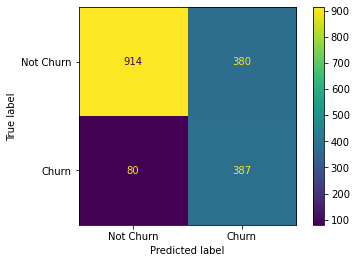

In [43]:
plot_confusion_matrix(clf_xgb,
                     X_test,
                     y_test,
                     values_format = 'd',
                     display_labels = ["Not Churn","Churn"])

[15:28:44] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:576: 
Parameters: { "learn_rate" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[15:28:44] WARNING: /Users/runner/miniforge3/conda-bld/xgboost-split_1645117948562/work/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
weight: {'Dependents': 1.0, 'tenure': 3.0, 'MonthlyCharges': 5.0, 'TotalCharges': 1.0, 'InternetService_Fiber_optic': 1.0, 'Contract_Month-to-month': 1.0, 'Contract_Two_year': 2.0}
gain: {'Dependents': 5.587089538574219, 'tenure': 85.1084976196289, 'Monthly

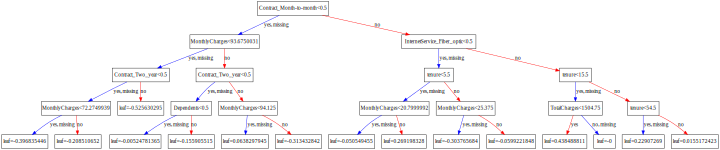

In [47]:
clf_xgb = xgb.XGBClassifier(seed = 42,
                           objective = 'binary:logistic',
                           gamma = 0.25,
                           learn_rate = 0.1,
                           max_depth = 4,
                           reg_lambda = 10,
                           scale_pos_weight = 3,
                           subsample = 0.9,
                           colsample_bytree = 0.5,
                           n_estimators = 1)
clf_xgb.fit(X_train, y_train)

bst = clf_xgb.get_booster()
for importance_type in ('weight','gain','cover','total_gain','total_cover'):
    print('%s:'% importance_type, bst.get_score(importance_type = importance_type))
    
node_params = {'shape': 'box',
              'stype': 'filled,round',
              'fillcolor': '#78cbe'}

leaf_params = {'shape': 'box',
              'stype': 'filled',
              'fillcolor': '#7e48038'}


xgb.to_graphviz(clf_xgb, num_tree = 0, size = "10,10",
               condition_node_params = node_params,
               leaf_node_params = leaf_params)


In [50]:
test_result = clf_xgb.predict(X_test)

confusion_matrix = confusion_matrix(y_test, test_result)

confusion_matrix 

array([[997, 297],
       [120, 347]])

In [53]:
print(classification_report(y_test, test_result))

              precision    recall  f1-score   support

           0       0.89      0.77      0.83      1294
           1       0.54      0.74      0.62       467

    accuracy                           0.76      1761
   macro avg       0.72      0.76      0.73      1761
weighted avg       0.80      0.76      0.77      1761

